#* **이 ipynb의 앞부분의 내용은 최종 notebook에 포함되는 이전 강의 복습내용 입니다.**
- **기말고사 내용인 cifar10 데이터에 대한 분류 정확도가 높은 모델을 만드는 방법과 최적 모델은 이 notebook 뒷부분에 있습니다.**

##**기말고사**
### **mnist, fmnist, cifar10 순으로 간단한 CNN 모델의 성능(정확도)이 낮아지는 이유는 무엇입니까?**

mnist, fmnist, cifar10 순으로 CNN 모델의 성능(정확도)이 낮아지는 이유는 점점 갈수록 성능을 올리기에는 다소 적은 dataset이기 때문이다. 큰 dataset을 사용하면 학습 데이터를 늘리면 오차가 작아져 성능이 높이는 데 효율적이라고 볼 수 있다.

# **CNN model of cifar-10 dataset**
- Conv2D + FCN
    * Conv2D : 2차원 합성곱 필터링 + 풀링(Pooling)
    * FCN : 1차원 완전연결신경망

***
- ## Traget: Find the best model
***

![mnist_NN_2_layers](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FdJp5Z6%2FbtqAPebnF3x%2FQCe5vVcskhmxe964bGz4iK%2Fimg.png)

(source: https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FdJp5Z6%2FbtqAPebnF3x%2FQCe5vVcskhmxe964bGz4iK%2Fimg.png)

### CIFAR-10 Dataset (CIFAR: Canadian Institute For Advanced Research)
> https://www.cs.toronto.edu/~kriz/cifar.html

- (50000, 32, 32, 3), train
- (10000, 32, 32, 3), test
- color photographs of objects from 10 classes, such as frogs, birds, cats, ships, etc
> class names
> - ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

- 참고 문헌  

> https://becominghuman.ai/cifar-10-image-classification-fd2ace47c5e8  

> https://becominghuman.ai/convolutional-neural-networks-cnns-convnets-for-visual-recognition-cae879a70f1a

> https://towardsdatascience.com/cifar-10-image-classification-in-tensorflow-5b501f7dc77c

## Search the best model of C2F2
- callback
    - Early stopping
    - model checkpoint

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

tf.random.set_seed(0)

print(tf.__version__)

2.3.0


In [ ]:
# import TF2 submodules
from tensorflow.keras import layers, models, callbacks

## **데이터 로딩, 정규화**

In [ ]:
from keras.datasets import cifar10

(X_train0, y_train0), (X_test0, y_test0) = cifar10.load_data()

# Reshape
# X_train = X_train0.reshape(60000,28,28,1)
# X_test = X_test0.reshape(10000,28,28,1)

# Normalization
X_train, X_test = X_train0/255.0, X_test0/255.0 # 정규화

print("X_train={0}".format(X_train.shape))
print("y_train={0}".format(y_train0.shape)) 
print("X_test={0}".format(X_test.shape))
print("y_test={0}".format(y_test0.shape))

170500096/170498071 [==============================] - 2s 0us/step
X_train=(50000, 32, 32, 3)
y_train=(50000, 1)
X_test=(10000, 32, 32, 3)
y_test=(10000, 1)


In [ ]:
# One-Hot-Encoding
# Use function to_categorical() to do One-Hot-Encoding
# tf.keras.utils.to_categorical
from keras.utils import to_categorical

y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)
y_train.shape,y_test.shape

((50000, 10), (10000, 10))

In [ ]:
# y_train0.shape vs. y_train.shape
y_train0.shape, y_train.shape

((50000, 1), (50000, 10))

### Display images in CIFAR-10
- one random image
- 10 representative images

47606


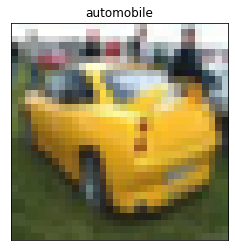

In [ ]:
# 랜덤으로 하나만 출력
# Code here!
# display one random image from the training set:
class_names =  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

idx = np.random.randint(0, X_train0.shape[0])
print(idx)
image = X_train0[idx]
plt.imshow(image) #, cmap=plt.get_cmap('gray'))
plt.title(class_names[y_train0[idx][0]])
plt.xticks([])
plt.yticks([])
plt.show()

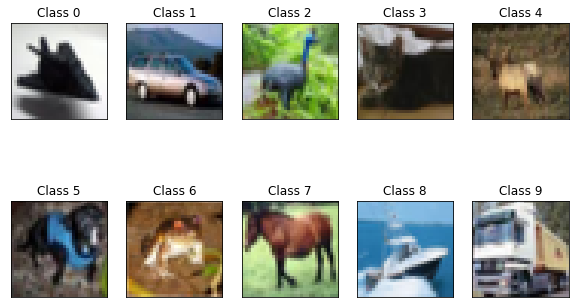

In [ ]:
# 대표 그림 출력
fig = plt.figure(figsize=(10,6))
num0_9 = np.unique(y_train0, return_index=True)[1]
images = X_train[num0_9]
for i in range(10):
    plt.subplot(2, 5, i+1)
    # num0_9 = X_train0[y_train0 == i]
    
    # print(num0_9.shape)
    # plt.imshow(num0_9[0]) 
    plt.imshow(images[i])
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])

# Design CNN

### import models, layers, callbacks
- models: Sequential
- layers: Conv2D, MaxPool2D, Flatten
- callbacks: ModelCheckpoint, EarlyStopping

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping

## **CNN2 + FCN2**

In [ ]:
c2f2 = keras.models.Sequential([ 
    Conv2D(input_shape=(32,32,3),kernel_size=(3,3),strides=(1,1),filters= 32,padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)), 
    Conv2D(kernel_size=(3,3),strides=(1,1),filters= 64,padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
    Flatten(), 
    keras.layers.Dense(128, activation='relu'),  
    keras.layers.Dropout(0.25), 
    keras.layers.Dense(10, activation='softmax')
])

c2f2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']) 

In [ ]:
c2f2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               524416    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

In [ ]:
cp_callback = callbacks.ModelCheckpoint(filepath="./cifar10_c2f2_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=25)    # patience=10, 25, 50

In [ ]:
hist = c2f2.fit(X_train, y_train, epochs = 500 , batch_size =32, 
         callbacks=[cp_callback, es_callback], 
         validation_data=(X_test,y_test))

Epoch 1/500
1563/1563 [==============================] - 6s 4ms/step - loss: 1.5062 - accuracy: 0.4558 - val_loss: 1.2203 - val_accuracy: 0.5683
Epoch 2/500
1563/1563 [==============================] - 6s 4ms/step - loss: 1.1760 - accuracy: 0.5835 - val_loss: 1.0462 - val_accuracy: 0.6287
Epoch 3/500
1563/1563 [==============================] - 6s 4ms/step - loss: 1.0479 - accuracy: 0.6298 - val_loss: 0.9851 - val_accuracy: 0.6490
Epoch 4/500
1563/1563 [==============================] - 6s 4ms/step - loss: 0.9590 - accuracy: 0.6628 - val_loss: 0.9643 - val_accuracy: 0.6604
Epoch 5/500
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8958 - accuracy: 0.6829 - val_loss: 0.8918 - val_accuracy: 0.6850
Epoch 6/500
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8383 - accuracy: 0.7022 - val_loss: 0.8575 - val_accuracy: 0.7030
Epoch 7/500
1563/1563 [==============================] - 6s 4ms/step - loss: 0.7870 - accuracy: 0.7223 - val_loss: 0.8893 - val_ac

In [ ]:
c2f2.evaluate(X_test, y_test, batch_size =32)

313/313 [==============================] - 1s 3ms/step - loss: 1.7374 - accuracy: 0.6927


[1.7374378442764282, 0.6927000284194946]

## **CNN2 + FCN3**

In [ ]:
c2f3 = keras.models.Sequential([ 
    Conv2D(input_shape=(32,32,3),kernel_size=(3,3),strides=(1,1),filters= 32,padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)), 
    Conv2D(kernel_size=(3,3),strides=(1,1),filters= 64,padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
    Flatten(), 
    keras.layers.Dense(128, activation='relu'),  
    keras.layers.Dropout(0.25), 
    keras.layers.Dense(64, activation='relu'),  
    keras.layers.Dropout(0.25), 
    keras.layers.Dense(10, activation='softmax')
])

c2f3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']) 

In [ ]:
c2f3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               524416    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

In [ ]:
cp_callback = callbacks.ModelCheckpoint(filepath="./cifar10_c2f3_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=25)    # patience=10, 25, 50

In [ ]:
c2f3.fit(X_train, y_train, epochs=500, batch_size =32, 
         callbacks=[cp_callback, es_callback], 
         validation_data=(X_test,y_test))

Epoch 1/500
1563/1563 [==============================] - 6s 4ms/step - loss: 1.5710 - accuracy: 0.4281 - val_loss: 1.2091 - val_accuracy: 0.5667
Epoch 2/500
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2057 - accuracy: 0.5766 - val_loss: 1.0509 - val_accuracy: 0.6331
Epoch 3/500
1563/1563 [==============================] - 6s 4ms/step - loss: 1.0644 - accuracy: 0.6291 - val_loss: 0.9589 - val_accuracy: 0.6654
Epoch 4/500
1563/1563 [==============================] - 6s 4ms/step - loss: 0.9728 - accuracy: 0.6632 - val_loss: 0.9513 - val_accuracy: 0.6708
Epoch 5/500
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8961 - accuracy: 0.6871 - val_loss: 0.9144 - val_accuracy: 0.6865
Epoch 6/500
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8335 - accuracy: 0.7102 - val_loss: 0.8785 - val_accuracy: 0.6937
Epoch 7/500
1563/1563 [==============================] - 6s 4ms/step - loss: 0.7861 - accuracy: 0.7269 - val_loss: 0.8692 - val_ac

In [ ]:
 c2f3.evaluate(X_test, y_test, batch_size = 32)

313/313 [==============================] - 1s 3ms/step - loss: 1.5371 - accuracy: 0.6992


[1.5371333360671997, 0.6991999745368958]

# **[DIY] Hidden layer에 따른 정확도**

In [ ]:
score1=c2f2.evaluate(X_test, y_test, batch_size = 32)
score2=c2f3.evaluate(X_test, y_test, batch_size = 32)
losses = [score1[0],score2[0]]
accuracies= [score1[1],score2[1]]
losses,accuracies

313/313 [==============================] - 1s 3ms/step - loss: 1.5371 - accuracy: 0.6992


([1.7374378442764282, 1.5371333360671997],
 [0.6927000284194946, 0.6991999745368958])

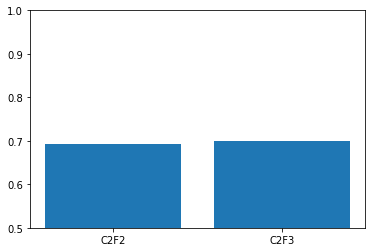

In [ ]:
x = np.arange(2)
cnns = ['C2F2','C2F3']

plt.bar(x, accuracies)
plt.xticks(x, cnns)
plt.ylim((.5,1.0))
plt.show()

## Complex model
- C4F5 model

![cnn_c4f5.png](https://raw.githubusercontent.com/Redwoods/Py/master//pdm2020/my-note/py-tensorflow/images/cnn_c4f5.png)

In [ ]:
c4f5 = keras.models.Sequential([ 
    Conv2D(input_shape=(32,32,3),kernel_size=(3,3),strides=(1,1),filters= 64,padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)), 
    Conv2D(kernel_size=(3,3),strides=(1,1),filters= 128,padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
    Conv2D(kernel_size=(3,3),strides=(1,1),filters= 256,padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
    Conv2D(kernel_size=(3,3),strides=(1,1),filters= 512,padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
    Flatten(), 
    keras.layers.Dense(128, activation='relu'),  
    keras.layers.Dropout(0.25), 
    keras.layers.Dense(256, activation='relu'),  
    keras.layers.Dropout(0.25), 
    keras.layers.Dense(512, activation='relu'),  
    keras.layers.Dropout(0.25), 
    keras.layers.Dense(1024, activation='relu'),  
    keras.layers.Dropout(0.25), 
    keras.layers.Dense(10, activation='softmax')
])

c4f5.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']) 

In [ ]:
c4f5.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 256)         295168    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 512)        

In [ ]:
cp_callback = callbacks.ModelCheckpoint(filepath="./cifar10_c4f5_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=25)    # patience=10, 25, 50

In [ ]:
c4f5.fit(X_train, y_train, epochs=500, batch_size =32, 
         callbacks=[cp_callback, es_callback], 
         validation_data=(X_test,y_test))

Epoch 1/500
1563/1563 [==============================] - 11s 7ms/step - loss: 1.6264 - accuracy: 0.3833 - val_loss: 1.2385 - val_accuracy: 0.5453
Epoch 2/500
1563/1563 [==============================] - 11s 7ms/step - loss: 1.1941 - accuracy: 0.5786 - val_loss: 1.0132 - val_accuracy: 0.6435
Epoch 3/500
1563/1563 [==============================] - 11s 7ms/step - loss: 0.9996 - accuracy: 0.6586 - val_loss: 0.9468 - val_accuracy: 0.6768
Epoch 4/500
1563/1563 [==============================] - 11s 7ms/step - loss: 0.8755 - accuracy: 0.7045 - val_loss: 0.9383 - val_accuracy: 0.6821
Epoch 5/500
1563/1563 [==============================] - 11s 7ms/step - loss: 0.7936 - accuracy: 0.7331 - val_loss: 0.9402 - val_accuracy: 0.6811
Epoch 6/500
1563/1563 [==============================] - 11s 7ms/step - loss: 0.7220 - accuracy: 0.7582 - val_loss: 0.8258 - val_accuracy: 0.7214
Epoch 7/500
1563/1563 [==============================] - 11s 7ms/step - loss: 0.6593 - accuracy: 0.7819 - val_loss: 0.9202 -

In [ ]:
 c4f5.evaluate(X_test, y_test, batch_size = 32)

313/313 [==============================] - 1s 3ms/step - loss: 1.1356 - accuracy: 0.7384


[1.1355992555618286, 0.7383999824523926]

## Graph of loss and accuracy
- model: C4f5

In [ ]:
c4f5 = keras.models.Sequential([ 
    Conv2D(input_shape=(32,32,3),kernel_size=(3,3),strides=(1,1),filters= 64,padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)), 
    Conv2D(kernel_size=(3,3),strides=(1,1),filters= 128,padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
    Conv2D(kernel_size=(3,3),strides=(1,1),filters= 256,padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
    Conv2D(kernel_size=(3,3),strides=(1,1),filters= 512,padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
    Flatten(), 
    keras.layers.Dense(128, activation='relu'),  
    keras.layers.Dropout(0.25), 
    keras.layers.Dense(256, activation='relu'),  
    keras.layers.Dropout(0.25), 
    keras.layers.Dense(512, activation='relu'),  
    keras.layers.Dropout(0.25), 
    keras.layers.Dense(1024, activation='relu'),  
    keras.layers.Dropout(0.25), 
    keras.layers.Dense(10, activation='softmax')
])

c4f5.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
epoch = 44
hist = c4f5.fit(X_train, y_train, 
         epochs = epoch, 
         batch_size =32, 
         validation_data=(X_test,y_test))

Epoch 1/44
1563/1563 [==============================] - 11s 7ms/step - loss: 1.6653 - accuracy: 0.3687 - val_loss: 1.3161 - val_accuracy: 0.5175
Epoch 2/44
1563/1563 [==============================] - 11s 7ms/step - loss: 1.2483 - accuracy: 0.5564 - val_loss: 1.1044 - val_accuracy: 0.6100
Epoch 3/44
1563/1563 [==============================] - 11s 7ms/step - loss: 1.0549 - accuracy: 0.6364 - val_loss: 0.9928 - val_accuracy: 0.6586
Epoch 4/44
1563/1563 [==============================] - 11s 7ms/step - loss: 0.9267 - accuracy: 0.6838 - val_loss: 0.9664 - val_accuracy: 0.6737
Epoch 5/44
1563/1563 [==============================] - 11s 7ms/step - loss: 0.8366 - accuracy: 0.7183 - val_loss: 0.9240 - val_accuracy: 0.7002
Epoch 6/44
1563/1563 [==============================] - 11s 7ms/step - loss: 0.7566 - accuracy: 0.7490 - val_loss: 0.9135 - val_accuracy: 0.6953
Epoch 7/44
1563/1563 [==============================] - 11s 7ms/step - loss: 0.6988 - accuracy: 0.7695 - val_loss: 0.9482 - val_ac

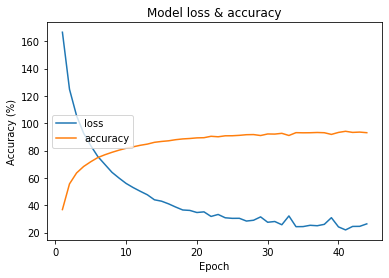

In [ ]:
# Plot loass and accuracy
# Plot training & validation accuracy values
epochs = epoch
loss_list = [100 * i for i in hist.history['loss']]
acc_list = [100 * i for i in hist.history['accuracy']]
plt.plot(range(1,epochs+1),loss_list) 
plt.plot(range(1,epochs+1),acc_list) 
plt.title('Model loss & accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['loss', 'accuracy'], loc='center left')

In [ ]:
vloss_list = [100 * i for i in hist.history['val_loss']]
vacc_list = [100 * i for i in hist.history['val_accuracy']]

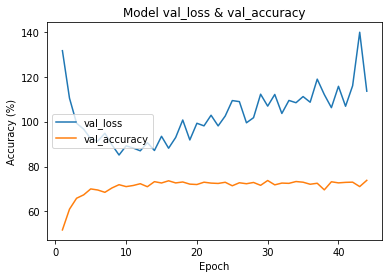

In [ ]:
plt.plot(range(1,epochs+1),vloss_list)  
plt.plot(range(1,epochs+1),vacc_list)  
plt.title('Model val_loss & val_accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['val_loss', 'val_accuracy'], loc='center left')

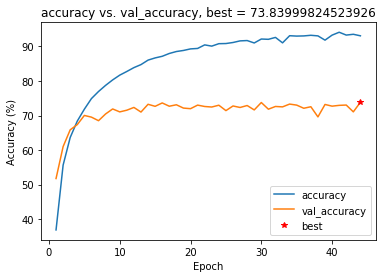

In [ ]:
plt.plot(range(1,epochs+1),acc_list)  
plt.plot(range(1,epochs+1),vacc_list)  
plt.plot(np.argmax(np.array(vacc_list))+1,vacc_list[np.argmax(np.array(vacc_list))], 'r*') 
plt.title('accuracy vs. val_accuracy, best = ' +str(vacc_list[np.argmax(np.array(vacc_list))]))
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['accuracy','val_accuracy','best']) #, loc='center bottom')

## cifar10 모델 학습
> https://gruuuuu.github.io/machine-learning/cifar10-cnn/#

## 모형의 저장

- 트레이닝이 끝난 모형은 save 메서드로 가중치와 함께 hdf5 형식으로 저장
- load 명령으로 불러 사용

In [ ]:
# c2f2.save('fmnist_cnn_best.hdf5')

In [ ]:
from keras.models import load_model

model = load_model('cifar10_c4f5_best_weights.019-0.7513.hdf5')
model.evaluate(X_test, y_test, batch_size=32)

313/313 [==============================] - 1s 3ms/step - loss: 0.9051 - accuracy: 0.7513


[0.905082643032074, 0.7512999773025513]

## Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
predictions = model.predict(X_test)

In [ ]:
predictions.shape

(10000, 10)

In [ ]:
predictions0 = np.argmax(predictions, axis=1)
predictions0.shape

(10000,)

In [ ]:
cm = confusion_matrix(y_test0, predictions0)

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

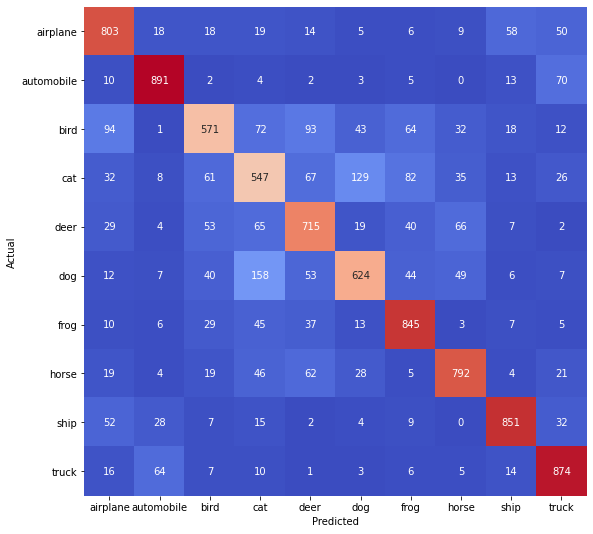

In [ ]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, cbar=False, xticklabels=class_names, yticklabels=class_names, fmt='d', annot=True, cmap=plt.cm.coolwarm)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# State of current scores of cifar-10

> https://paperswithcode.com/sota/image-classification-on-cifar-10

## Transfer learning on cifar-10

- https://medium.com/@andrew.dabydeen/transfer-learning-using-resnet50-and-cifar-10-6242ed4b4245

- https://medium.com/swlh/comparative-analysis-of-cifar-10-image-classification-transfer-learning-vs-user-defined-cnns-e673685d925e

- https://medium.com/swlh/hands-on-the-cifar-10-dataset-with-transfer-learning-2e768fd6c318

- https://medium.com/analytics-vidhya/the-transfer-learning-experience-with-vgg16-and-cifar-10-dataset-9b25b306a23f



---



#* **기말고사 과제**
- cifar10 데이터에 대한 분류 정확도가 높은 모델을 만드는 방법과 최적 모델을 구하시오.

In [ ]:
# import library
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

tf.random.set_seed(0)

print(tf.__version__)

2.3.0


In [ ]:
from tensorflow.keras import layers, models, callbacks
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping

# L2 정규화를 위한 라이브러리
from keras.regularizers import l2
# 배치 정규화 적용을 위한 층
from keras.layers import BatchNormalization

##**Load CIFAR-10 dataset**

In [ ]:
from keras.datasets import cifar10

(X_train0, y_train0), (X_test0, y_test0) = cifar10.load_data()

# Reshape
# X_train = X_train0.reshape(60000,28,28,1)
# X_test = X_test0.reshape(10000,28,28,1)

# Normalization
X_train, X_test = X_train0/255.0, X_test0/255.0 # 정규화

print("X_train={0}".format(X_train.shape))
print("y_train={0}".format(y_train.shape)) 
print("X_test={0}".format(X_test.shape))
print("y_test={0}".format(y_test.shape))

X_train=(50000, 32, 32, 3)
y_train=(50000, 10)
X_test=(10000, 32, 32, 3)
y_test=(10000, 10)


In [ ]:
# One-Hot-Encoding
# Use function to_categorical() to do One-Hot-Encoding
# tf.keras.utils.to_categorical
from keras.utils import to_categorical

y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)
y_train.shape,y_test.shape

((50000, 10), (10000, 10))

In [ ]:
# y_train0.shape vs. y_train.shape
y_train0.shape, y_train.shape

((50000, 1), (50000, 10))

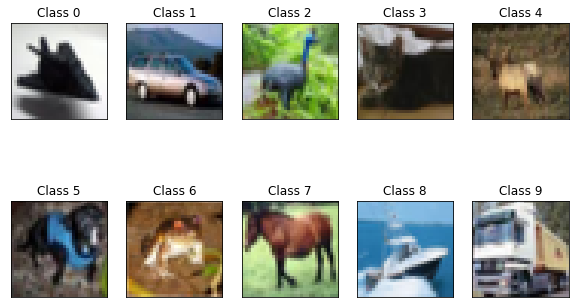

In [ ]:
# cifar-10 대표 이미지 보기
fig = plt.figure(figsize=(10,6))
num0_9 = np.unique(y_train0, return_index=True)[1]
images = X_train[num0_9]
for i in range(10):
    plt.subplot(2, 5, i+1)
    # num0_9 = X_train0[y_train0 == i]
    
    # print(num0_9.shape)
    # plt.imshow(num0_9[0]) 
    plt.imshow(images[i])
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])

In [ ]:
# 순차적 모델을 위해 Sequential() 함수 사용
best_model = Sequential(name='CIFAR-10_Best_model')
# padding : 'same'-> 입력과 출력 모양이 같도록 0을 주변에 덧댄다
# best model을 찾기 위해 elu : relu 보다 발전된 형태의 활성화 함수 elu를 사용
# kernel_regularizer : 가중치 규제를 정해줌 -> l2(lambda) : 가중치의 L2 Norm을 목적 함수에 추가하며, lambda에 따라 곱해지는 상수값을 정함

best_model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.0001),
                 input_shape=(32, 32, 3), activation='elu'))
best_model.add(BatchNormalization()) # BatchNormalization() : 배치 정규화를 위한 층을 추가
best_model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.0001), activation='elu'))
best_model.add(BatchNormalization())
# pool_size : MaxPooling 의 Window size
best_model.add(MaxPooling2D(pool_size=(2, 2)))
best_model.add(Dropout(0.2)) # Dropout(rate) : 앞의 층에 드롭아웃을 적용. rate값에 의해 없애고 학습할 비율
best_model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.0001), activation='elu'))
best_model.add(BatchNormalization())
best_model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.0001), activation='elu'))
best_model.add(BatchNormalization())
best_model.add(MaxPooling2D(pool_size=(2, 2)))
best_model.add(Dropout(0.3))
best_model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.0001), activation='elu'))
best_model.add(BatchNormalization())
best_model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.0001), activation='elu'))
best_model.add(BatchNormalization())
best_model.add(MaxPooling2D(pool_size=(2, 2)))
best_model.add(Dropout(0.4))
# N차원 배열을 1차원으로 펴줌
best_model.add(Flatten())
# 출력층 MLP
best_model.add(Dense(10, activation='softmax'))

# categorical_crossentropy : 분류가 2개 이상인 CEE
# loss : 목적 함수
# optimizer : adam을 사용
# metrics : 학습 도중 화면에 어떤 값을 출력할지 결정
best_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
best_model.summary()

Model: "CIFAR-10_Best model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_115 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_78 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_116 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_79 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_61 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 16, 16, 64)

Batch Normalization 층으로 인해서 학습 불가한 params가 생김

* Batch Normalization: 학습률을 너무 높게 잡았을 때 기울기가 소실되거나 발산하는 현상을 예방하여 학습 과정을 안정화하는 것이다. 

학습 중 각 계층에 들어가는 입력을 평균과 분산으로 정규화함으로써 학습을 효율적으로 만들어주고, overfitting을 막는 dropout과 같은 효과를 낸다. 

dropout과 차이점은 dropout이 데이터 일부를 배제하여 간접적으로 과적합을 막는 것이고, 배치 정규화는 신경망 내부 데이터에 직접 영향을 준다는 것이다.

In [ ]:
# callback
cp_callback = callbacks.ModelCheckpoint(filepath="./cifar10_final_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=25)    # patience=10, 25, 50

In [ ]:
# model 학습
hist = best_model.fit(X_train, y_train, epochs=500, batch_size =32, 
         callbacks=[cp_callback, es_callback], 
         validation_data=(X_test,y_test))

Epoch 1/500
1563/1563 [==============================] - 10s 7ms/step - loss: 1.6642 - accuracy: 0.4871 - val_loss: 1.2602 - val_accuracy: 0.5929
Epoch 2/500
1563/1563 [==============================] - 10s 6ms/step - loss: 1.0542 - accuracy: 0.6585 - val_loss: 0.9714 - val_accuracy: 0.6895
Epoch 3/500
1563/1563 [==============================] - 10s 6ms/step - loss: 0.8966 - accuracy: 0.7144 - val_loss: 0.8409 - val_accuracy: 0.7399
Epoch 4/500
1563/1563 [==============================] - 10s 6ms/step - loss: 0.8094 - accuracy: 0.7499 - val_loss: 0.8251 - val_accuracy: 0.7485
Epoch 5/500
1563/1563 [==============================] - 10s 6ms/step - loss: 0.7571 - accuracy: 0.7750 - val_loss: 0.7545 - val_accuracy: 0.7842
Epoch 6/500
1563/1563 [==============================] - 10s 6ms/step - loss: 0.7240 - accuracy: 0.7931 - val_loss: 0.7447 - val_accuracy: 0.7964
Epoch 7/500
1563/1563 [==============================] - 10s 6ms/step - loss: 0.6941 - accuracy: 0.8096 - val_loss: 0.7093 -

In [ ]:
best_model.evaluate(X_test, y_test, batch_size = 32)

313/313 [==============================] - 1s 4ms/step - loss: 0.6948 - accuracy: 0.8604


[0.6947923898696899, 0.8604000210762024]

##**Graph of loss and accuracy**
- my best model

In [ ]:
# 순차적 모델을 위해 Sequential() 함수 사용
best_model = Sequential(name='CIFAR-10_Best_model')
# padding : 'same'-> 입력과 출력 모양이 같도록 0을 주변에 덧댄다
# best model을 찾기 위해 elu : relu 보다 발전된 형태의 활성화 함수 elu를 사용
# kernel_regularizer : 가중치 규제를 정해줌 -> l2(lambda) : 가중치의 L2 Norm을 목적 함수에 추가하며, lambda에 따라 곱해지는 상수값을 정함

best_model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.0001),
                 input_shape=(32, 32, 3), activation='elu'))
best_model.add(BatchNormalization()) # BatchNormalization() : 배치 정규화를 위한 층을 추가
best_model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.0001), activation='elu'))
best_model.add(BatchNormalization())
# pool_size : MaxPooling 의 Window size
best_model.add(MaxPooling2D(pool_size=(2, 2)))
best_model.add(Dropout(0.2)) # Dropout(rate) : 앞의 층에 드롭아웃을 적용. rate값에 의해 없애고 학습할 비율
best_model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.0001), activation='elu'))
best_model.add(BatchNormalization())
best_model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.0001), activation='elu'))
best_model.add(BatchNormalization())
best_model.add(MaxPooling2D(pool_size=(2, 2)))
best_model.add(Dropout(0.3))
best_model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.0001), activation='elu'))
best_model.add(BatchNormalization())
best_model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.0001), activation='elu'))
best_model.add(BatchNormalization())
best_model.add(MaxPooling2D(pool_size=(2, 2)))
best_model.add(Dropout(0.4))
# N차원 배열을 1차원으로 펴줌
best_model.add(Flatten())
# 출력층 MLP
best_model.add(Dense(10, activation='softmax'))

# categorical_crossentropy : 분류가 2개 이상인 CEE
# loss : 목적 함수
# optimizer : adam을 사용
# metrics : 학습 도중 화면에 어떤 값을 출력할지 결정
best_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
epoch = 79
hist = best_model.fit(X_train, y_train, 
         epochs = epoch, 
         batch_size =32, 
         validation_data=(X_test,y_test))

Epoch 1/79
1563/1563 [==============================] - 10s 7ms/step - loss: 1.6645 - accuracy: 0.4885 - val_loss: 1.0908 - val_accuracy: 0.6432
Epoch 2/79
1563/1563 [==============================] - 10s 6ms/step - loss: 1.0608 - accuracy: 0.6576 - val_loss: 0.9990 - val_accuracy: 0.6764
Epoch 3/79
1563/1563 [==============================] - 10s 7ms/step - loss: 0.8983 - accuracy: 0.7127 - val_loss: 0.9170 - val_accuracy: 0.7189
Epoch 4/79
1563/1563 [==============================] - 10s 6ms/step - loss: 0.8143 - accuracy: 0.7465 - val_loss: 0.7708 - val_accuracy: 0.7699
Epoch 5/79
1563/1563 [==============================] - 10s 7ms/step - loss: 0.7614 - accuracy: 0.7718 - val_loss: 0.7307 - val_accuracy: 0.7869
Epoch 6/79
1563/1563 [==============================] - 10s 6ms/step - loss: 0.7241 - accuracy: 0.7938 - val_loss: 0.7229 - val_accuracy: 0.7993
Epoch 7/79
1563/1563 [==============================] - 10s 6ms/step - loss: 0.6951 - accuracy: 0.8087 - val_loss: 0.7181 - val_ac

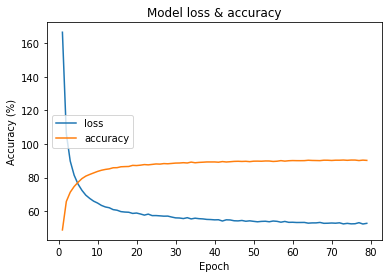

In [ ]:
# Plot loass and accuracy
# Plot training & validation accuracy values
epochs = epoch
loss_list = [100 * i for i in hist.history['loss']]
acc_list = [100 * i for i in hist.history['accuracy']]
plt.plot(range(1,epochs+1),loss_list) 
plt.plot(range(1,epochs+1),acc_list) 
plt.title('Model loss & accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['loss', 'accuracy'], loc='center left')

In [ ]:
vloss_list = [100 * i for i in hist.history['val_loss']]
vacc_list = [100 * i for i in hist.history['val_accuracy']]

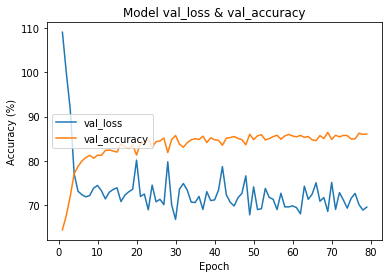

In [ ]:
plt.plot(range(1,epochs+1),vloss_list)  
plt.plot(range(1,epochs+1),vacc_list)  
plt.title('Model val_loss & val_accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['val_loss', 'val_accuracy'], loc='center left')

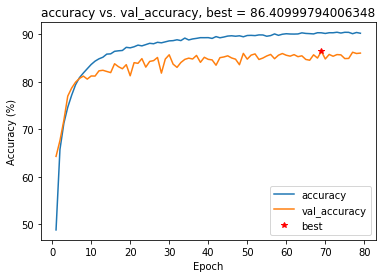

In [ ]:
plt.plot(range(1,epochs+1),acc_list)  
plt.plot(range(1,epochs+1),vacc_list)  
plt.plot(np.argmax(np.array(vacc_list))+1,vacc_list[np.argmax(np.array(vacc_list))], 'r*') 
plt.title('accuracy vs. val_accuracy, best = ' +str(vacc_list[np.argmax(np.array(vacc_list))]))
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['accuracy','val_accuracy','best']) #, loc='center bottom')

###**모형의 저장**
* 트레이닝이 끝난 모형은 save 메서드로 가중치와 함께 hdf5 형식으로 저장
* load 명령으로 불러 사용

cifar10_final_best_weights.054-0.8624.hdf5

In [ ]:
# c2f2.save('fmnist_cnn_best.hdf5')

In [ ]:
from keras.models import load_model

model = load_model('cifar10_final_best_weights.054-0.8624.hdf5')
model.evaluate(X_test, y_test, batch_size=32)

313/313 [==============================] - 1s 4ms/step - loss: 0.6792 - accuracy: 0.8624


[0.6792362928390503, 0.8623999953269958]

##**Confusion matrix**

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
predictions = model.predict(X_test)

In [ ]:
predictions.shape

(10000, 10)

In [ ]:
predictions0 = np.argmax(predictions, axis=1)
predictions0.shape

(10000,)

In [ ]:
cm = confusion_matrix(y_test0, predictions0)

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

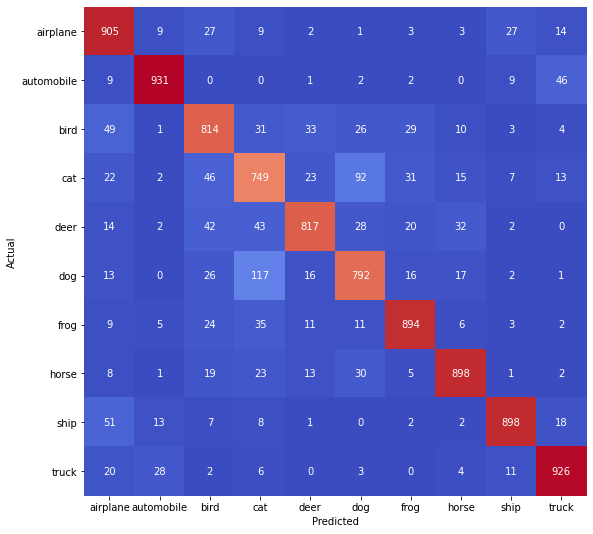

In [ ]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, cbar=False, xticklabels=class_names, yticklabels=class_names, fmt='d', annot=True, cmap=plt.cm.coolwarm)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#**model predict**

predict: cat / outcome: cat


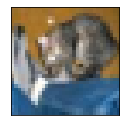

predict: ship / outcome: ship


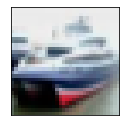

predict: ship / outcome: ship


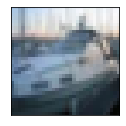

predict: airplane / outcome: airplane


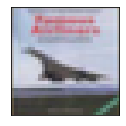

predict: frog / outcome: frog


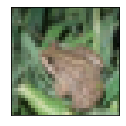

predict: frog / outcome: frog


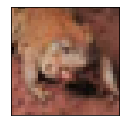

predict: automobile / outcome: automobile


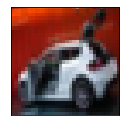

predict: frog / outcome: frog


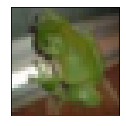

predict: cat / outcome: cat


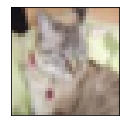

predict: automobile / outcome: automobile


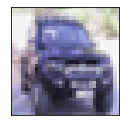

predict: airplane / outcome: airplane


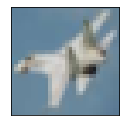

predict: truck / outcome: truck


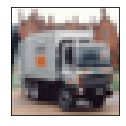

predict: dog / outcome: dog


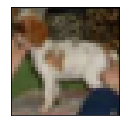

predict: horse / outcome: horse


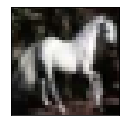

predict: truck / outcome: truck


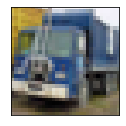

predict: ship / outcome: ship


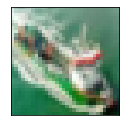

predict: dog / outcome: dog


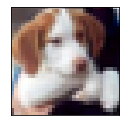

predict: horse / outcome: horse


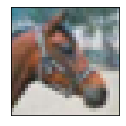

predict: ship / outcome: ship


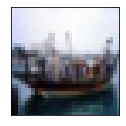

predict: frog / outcome: frog


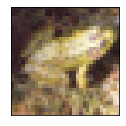

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.rcParams["figure.figsize"] = (2,2)
# 10 test set
for i in range(20):
  output = model.predict(X_test[i].reshape(1,32, 32, 3))

  # show image
  plt.imshow(X_test[i].reshape(32, 32, 3))
  print('predict: ' + class_names[np.argmax(output)] + ' / outcome: ' + class_names[np.argmax(y_test[i])])
  plt.xticks([])
  plt.yticks([])
  plt.show()